# Purpose
* trying to implement Beta Regression

## Notes
### Distribution
* [19.2 Beta proportion distribution](https://mc-stan.org/docs/2_27/functions-reference/beta-proportion-distribution.html)
* [BetaProportion](http://num.pyro.ai/en/stable/distributions.html#betaproportion)

### Examples
* [Uncovering Effective Love Teams Using Bayesian Beta Regression with Interactions](https://piocalderon.github.io/uncovering-effective-pinoy-loveteams-a-bayesian-approach/)
* [Zero One Inflated Beta Models for Proportion Data](https://www.theanalysisfactor.com/zero-one-inflated-beta-models-for-proportion-data/)
* [6840-10-19-5: 3.6 Beta Regression](https://www.youtube.com/watch?v=V0zg_6DJ3gk)
* [Bayesian Beta Regression](https://m-clark.github.io/models-by-example/bayesian-beta-regression.html)
* [Beta Regression in pyMC3](https://discourse.pymc.io/t/beta-regression-in-pymc3/301)
* [Beta Regression for Modelling rates and Proportions](https://www.ime.usp.br/~sferrari/beta.pdf)
* [A Guide to the Regression of Rates and Proportions](https://towardsdatascience.com/a-guide-to-the-regression-of-rates-and-proportions-bcfe1c35344f)
* [Regression of a Proportion in Python](https://danvatterott.com/blog/2018/05/03/regression-of-a-proportion-in-python/)

In [1]:
import arviz as az
import matplotlib as mpl
import numpy as np
import pandas as pd
from jax import numpy as jnp
from jax import ops, random
from jax.scipy.special import expit
from jax.scipy.stats import logistic
from jax.scipy.special import logit, expit
from matplotlib import pyplot as plt

import numpyro
from numpyro import distributions as dist
from numpyro.distributions import constraints
from numpyro.infer import MCMC, NUTS, Predictive

plt.style.use("seaborn")

In [2]:
font = {"size": 16}
mpl.rc("font", **font)

mpl.rcParams["figure.dpi"] = 100

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%load_ext watermark

In [4]:
%watermark -v -m -p numpy,matplotlib,pandas,sklearn,seaborn,statsmodels,scipy

Python implementation: CPython
Python version       : 3.8.11
IPython version      : 7.18.1

numpy      : 1.20.3
matplotlib : 3.4.3
pandas     : 1.3.2
sklearn    : 0.24.2
seaborn    : 0.11.2
statsmodels: 0.12.2
scipy      : 1.6.2

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 4.19.193-1-MANJARO
Machine     : x86_64
Processor   : 
CPU cores   : 4
Architecture: 64bit



In [5]:
%watermark -gb

Git hash: 307321cc497d1542d2908d60950823b102b16219

Git branch: master



### Beta Regression Toy Example
* Going to use the data generatoin process from [Bayesian Beta Regression](https://m-clark.github.io/models-by-example/bayesian-beta-regression.html)
* In the post the author uses `phi ~ cauchy(0, 5)` which is confusing to me because I think phi > 0, from [19.2 Beta proportion distribution](https://mc-stan.org/docs/2_27/functions-reference/beta-proportion-distribution.html) [**Note**: $\phi = \kappa$]
* I try a Cauchy(0,5) in `beta_regression_01`, but I don't recommend  using Cauchy(0,5)

#### Constant phi
- the toy example assumes a constant `phi`

In [6]:
key = random.PRNGKey(0)
keys = random.split(key, 5)

In [7]:
N = 500
x_1 = dist.Normal().sample(keys[0], (N,))
x_2 = dist.Normal().sample(keys[1], (N,))
X = jnp.stack([jnp.ones(N), x_1, x_2], axis=1)
beta = jnp.array([-1, 0.2, -0.3])
# mu   = logistic.pdf(jnp.dot(X,beta))
mu = expit(jnp.dot(X, beta))
phi = 10

A = mu * phi
B = (1 - mu) * phi

y = dist.Beta(A, B).sample(keys[2])

array([[<AxesSubplot:title={'center':'x'}>]], dtype=object)

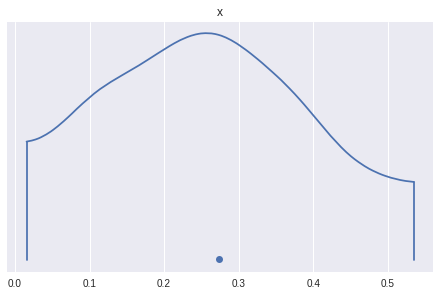

In [8]:
az.plot_density(np.array(y))

In [9]:
def beta_regression_00(data, obs=None):
    num_predictors = data.shape[1]
    phi = numpyro.sample("phi", dist.Exponential(rate=1.0,))
    betas = numpyro.sample(
        "betas", dist.Normal(jnp.zeros(num_predictors), jnp.ones(num_predictors))
    )
    mu = expit(jnp.sum(betas * data, axis=-1))

    alpha = mu * phi
    beta = (1.0 - mu) * phi

    return numpyro.sample("obs", dist.Beta(alpha, beta), obs=obs)

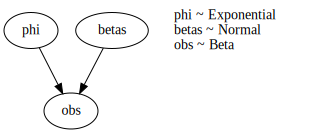

In [10]:
numpyro.render_model(
    beta_regression_00, (X[:10, :],), dict(obs=None), render_distributions=True
)

In [11]:
nuts_kernel = NUTS(beta_regression_00)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000, num_chains=4)
mcmc.run(keys[3], X, y, extra_fields=("potential_energy",))
mcmc.print_summary()

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1500/1500 [00:01<00:00, 1141.20it/s, 3 steps of size 7.91e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  betas[0]     -1.00      0.03     -1.00     -1.06     -0.95   3961.78      1.00
  betas[1]      0.18      0.03      0.18      0.13      0.24   4247.05      1.00
  betas[2]     -0.32      0.03     -0.32     -0.37     -0.27   4301.35      1.00
       phi      9.65      0.59      9.63      8.71     10.63   3732.25      1.00

Number of divergences: 0


In [12]:
ds = az.from_numpyro(mcmc)

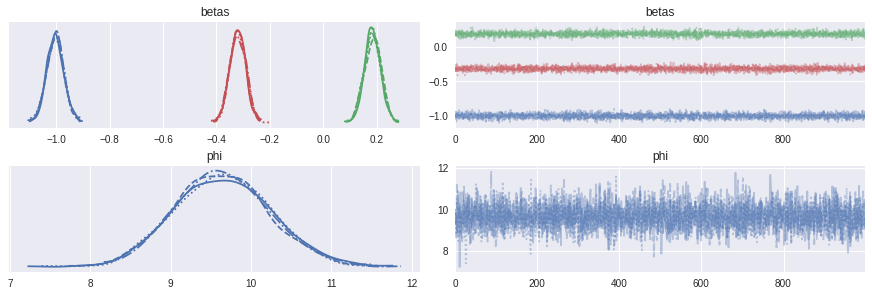

In [13]:
az.plot_trace(ds);

In [14]:
beta

DeviceArray([-1. ,  0.2, -0.3], dtype=float32)

In [15]:
def beta_regression_01(data, obs=None):
    num_predictors = data.shape[1]
    phi = numpyro.sample("phi", dist.Cauchy(loc=1.0, scale=5.0))
    betas = numpyro.sample(
        "betas", dist.Normal(jnp.zeros(num_predictors), jnp.ones(num_predictors))
    )
    mu = expit(jnp.sum(betas * data, axis=-1))

    alpha = mu * phi
    beta = (1.0 - mu) * phi

    return numpyro.sample("obs", dist.Beta(alpha, beta), obs=obs)

In [16]:
nuts_kernel = NUTS(beta_regression_01)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000, num_chains=4)
mcmc.run(keys[4], X, y, extra_fields=("potential_energy",))
mcmc.print_summary()

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1500/1500 [00:01<00:00, 1043.38it/s, 3 steps of size 8.36e-01. acc. prob=0.86]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  betas[0]     -1.01      0.03     -1.01     -1.06     -0.96   4230.39      1.00
  betas[1]      0.18      0.03      0.19      0.14      0.24   4310.09      1.00
  betas[2]     -0.32      0.03     -0.32     -0.37     -0.28   3627.74      1.00
       phi      9.97      0.63      9.95      8.90     10.96   3966.47      1.00

Number of divergences: 0


* Cauchy for phi is a terrible a choice, seen above

### Fit `phi` instead of assuming a constant
Ref [1] gives a good example on how to fit $\phi$ with another link function. The oringal data can be found at Ref [2].

Ref [1] [A better lemon squeezer? Maximum-likelihood regression with beta-distributed dependent variables.](https://europepmc.org/article/MED/16594767)
Ref [2] Original Data http://michaelsmithson.online/stats/betareg/betareg.html

## Example 1: 2x2 Factorial Design

In [17]:
ex1 = pd.read_csv("http://michaelsmithson.online/stats/betareg/Example1.txt", sep="\t")
ex1

,vert,confl,crc99
0,-1.0,-1.0,0.500
1,-1.0,-1.0,0.698
2,-1.0,-1.0,0.797
3,-1.0,-1.0,0.698
4,-1.0,-1.0,0.797
...,...,...,...
99,1.0,1.0,0.896
100,1.0,1.0,0.946
101,1.0,1.0,0.698
102,1.0,1.0,0.995


In [18]:
y = jnp.array(ex1["crc99"])
X = jnp.stack(
    [
        jnp.ones(ex1.shape[0]),
        ex1["vert"].values,
        ex1["confl"].values,
        (ex1["vert"] * ex1["confl"]).values,
    ],
    axis=1,
)

In [19]:
jnp.ones(104) * 10

DeviceArray([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
             10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
             10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
             10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
             10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
             10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
             10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
             10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
             10., 10., 10., 10., 10., 10., 10., 10.], dtype=float32)

In [20]:
def beta_regression_02(X, W, y=None):
    x_num_predictors = X.shape[1]
    w_num_predictors = W.shape[1]
    betas = numpyro.sample(
        "betas",
        dist.Normal(jnp.zeros(x_num_predictors), jnp.ones(x_num_predictors) * 10),
    )
    mu = expit(jnp.sum(betas * X, axis=-1))
    deltas = numpyro.sample(
        "deltas",
        dist.Normal(jnp.zeros(w_num_predictors), jnp.ones(w_num_predictors) * 10),
    )
    phi = jnp.exp(-(jnp.sum(deltas * W, axis=-1)))

    alpha = mu * phi
    beta = (1.0 - mu) * phi

    return numpyro.sample("y", dist.Beta(alpha, beta), obs=y)

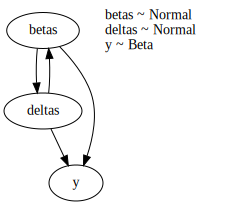

In [21]:
numpyro.render_model(
    beta_regression_02, (X, X), dict(y=None), render_distributions=True
)

In [22]:
with numpyro.handlers.seed(rng_seed=0), numpyro.handlers.trace() as t:
    beta_regression_02(X, X)
print(numpyro.util.format_shapes(t, compute_log_prob=True))

Trace Shapes:      
 Param Sites:      
Sample Sites:      
   betas dist   4 |
        value   4 |
     log_prob   4 |
  deltas dist   4 |
        value   4 |
     log_prob   4 |
       y dist 104 |
        value 104 |
     log_prob 104 |


In [23]:
nuts_kernel = NUTS(beta_regression_02)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000, num_chains=4)
mcmc.run(keys[5], X, X, y, extra_fields=("potential_energy",))
mcmc.print_summary()

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1500/1500 [00:00<00:00, 2863.49it/s, 7 steps of size 5.16e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  betas[0]      0.91      0.11      0.90      0.72      1.08   5118.22      1.00
  betas[1]      0.01      0.11      0.00     -0.16      0.20   5363.50      1.00
  betas[2]      0.17      0.11      0.17     -0.00      0.35   5676.34      1.00
  betas[3]      0.28      0.11      0.28      0.11      0.46   4411.21      1.00
 deltas[0]     -1.13      0.13     -1.13     -1.33     -0.91   5969.35      1.00
 deltas[1]      0.32      0.13      0.32      0.11      0.54   5693.60      1.00
 deltas[2]     -0.22      0.13     -0.22     -0.43     -0.01   5280.71      1.00
 deltas[3]     -0.31      0.13     -0.31     -0.51     -0.10   4502.70      1.00

Number of divergences: 0


In [24]:
ds = az.from_numpyro(mcmc)

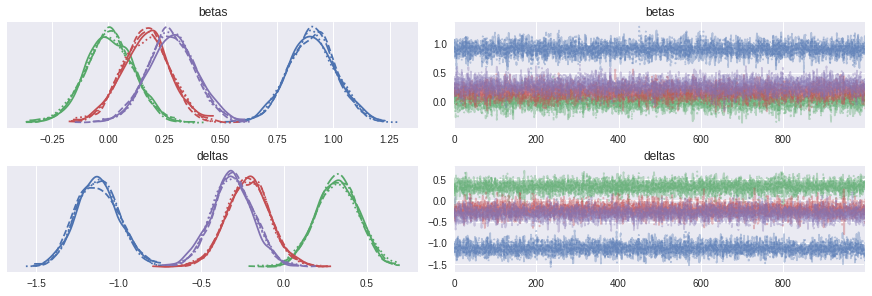

In [25]:
az.plot_trace(ds);

In [26]:
mcmc.get_samples()["betas"].mean(0)

DeviceArray([0.90585524, 0.00535015, 0.16635475, 0.28079653], dtype=float32)

In [27]:
mcmc.get_samples()["deltas"].mean(0)

DeviceArray([-1.1272175 ,  0.32150957, -0.2169815 , -0.31134   ], dtype=float32)

## Example 3: Sequential Regression With Dyslexiaand IQ Predicting Reading Accuracy

In [28]:
ex3 = pd.read_csv("http://michaelsmithson.online/stats/betareg/Example3.txt", sep="\t")
ex3

,accur01,grpctr,ziq
0,0.88386,-1,0.827
1,0.76524,-1,0.590
2,0.91508,-1,0.471
3,0.98376,-1,1.144
4,0.88386,-1,-0.676
5,0.70905,-1,-0.795
6,0.77148,-1,-0.281
7,0.99000,-1,-0.914
8,0.99000,-1,-0.043
9,0.99000,-1,0.907


```python
> ex3 <- read.table("Example3.txt", header = TRUE);attach(ex3)
> library(MASS)
> ydata <- cbind(accur01);
> const <- rep(1,length(ydata));
> xdata <- cbind(const, grpctr, ziq, grpctr*ziq);
> wdata <- cbind(const, grpctr, ziq);
```

In [29]:
ex3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   accur01  44 non-null     float64
 1   grpctr   44 non-null     int64  
 2   ziq      44 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.2 KB


In [30]:
ex3.columns

Index(['accur01', 'grpctr', 'ziq'], dtype='object')

In [31]:
y = jnp.array(ex3["accur01"])
X = jnp.stack(
    [
        jnp.ones(ex3.shape[0]),
        ex3["grpctr"].values,
        ex3["ziq"].values,
        (ex3["grpctr"] * ex3["ziq"]).values,
    ],
    axis=1,
)
W = jnp.stack([jnp.ones(ex3.shape[0]), ex3["grpctr"].values, ex3["ziq"].values], axis=1)

In [32]:
def beta_regression_03(X, W, y=None):
    x_num_predictors = X.shape[1]
    w_num_predictors = W.shape[1]
    betas = numpyro.sample(
        "betas",
        dist.Normal(jnp.zeros(x_num_predictors), jnp.ones(x_num_predictors) * 10),
    )
    mu = expit(jnp.sum(betas * X, axis=-1))
    deltas = numpyro.sample(
        "deltas",
        dist.Normal(jnp.zeros(w_num_predictors), jnp.ones(w_num_predictors) * 10),
    )
    phi = jnp.exp(-(jnp.sum(deltas * W, axis=-1)))

    alpha = mu * phi
    beta = (1.0 - mu) * phi

    return numpyro.sample("y", dist.Beta(alpha, beta), obs=y)

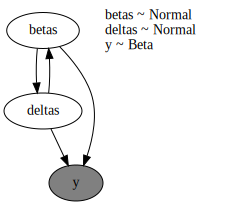

In [33]:
numpyro.render_model(beta_regression_03, (X, W), dict(y=y), render_distributions=True)

In [34]:
nuts_kernel = NUTS(beta_regression_03)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=2000, num_chains=4)
mcmc.run(keys[5], X, W, y, extra_fields=("potential_energy",))
mcmc.print_summary()

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 2500/2500 [00:01<00:00, 2194.32it/s, 15 steps of size 1.75e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  betas[0]      1.13      0.15      1.13      0.88      1.37   2456.39      1.00
  betas[1]     -0.75      0.15     -0.75     -1.01     -0.51   2445.63      1.00
  betas[2]      0.44      0.17      0.44      0.17      0.74   2213.55      1.00
  betas[3]     -0.53      0.18     -0.53     -0.83     -0.24   2117.82      1.00
 deltas[0]     -3.14      0.24     -3.15     -3.55     -2.75   2945.76      1.00
 deltas[1]     -1.61      0.31     -1.62     -2.10     -1.10   2334.82      1.00
 deltas[2]     -1.05      0.45     -1.06     -1.80     -0.32   2075.16      1.00

Number of divergences: 4


In [35]:
ds = az.from_numpyro(mcmc)

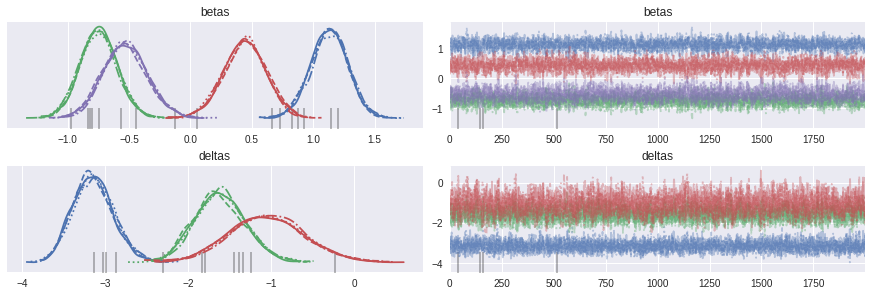

In [36]:
az.plot_trace(ds);

In [37]:
mcmc.get_samples()["betas"].mean(0)

DeviceArray([ 1.1293783 , -0.7476704 ,  0.4407099 , -0.52992624], dtype=float32)

In [38]:
int(np.sqrt(ex3.shape[0]))

6

In [40]:
jnp.ones(ex3.query("`grpctr` == 1").shape[0]).shape

(19,)

In [41]:
ex3.query("`grpctr` == 1")[["grpctr", "ziq"]].values.shape

(19, 2)

In [42]:
grpctr_mu_pos1 = jnp.concatenate(
    [
        jnp.ones((ex3.query("`grpctr` == 1").shape[0], 1)),
        ex3.query("`grpctr` == 1")[["grpctr", "ziq"]].values,
        (ex3.query("`grpctr` == 1")["grpctr"]*ex3.query("`grpctr` == 1")["ziq"]).values[:,None]
    ],
    axis=1,
)

In [43]:
grpctr_mu_pos1

DeviceArray([[ 1.   ,  1.   , -0.083, -0.083],
             [ 1.   ,  1.   , -0.162, -0.162],
             [ 1.   ,  1.   , -0.795, -0.795],
             [ 1.   ,  1.   , -0.281, -0.281],
             [ 1.   ,  1.   , -0.874, -0.874],
             [ 1.   ,  1.   ,  0.313,  0.313],
             [ 1.   ,  1.   ,  0.709,  0.709],
             [ 1.   ,  1.   ,  1.223,  1.223],
             [ 1.   ,  1.   , -1.23 , -1.23 ],
             [ 1.   ,  1.   , -0.162, -0.162],
             [ 1.   ,  1.   , -0.993, -0.993],
             [ 1.   ,  1.   , -1.191, -1.191],
             [ 1.   ,  1.   , -1.745, -1.745],
             [ 1.   ,  1.   , -1.745, -1.745],
             [ 1.   ,  1.   , -0.439, -0.439],
             [ 1.   ,  1.   , -1.666, -1.666],
             [ 1.   ,  1.   , -1.507, -1.507],
             [ 1.   ,  1.   , -0.518, -0.518],
             [ 1.   ,  1.   , -1.27 , -1.27 ]], dtype=float32)

In [44]:
grpctr_phi_pos1 = jnp.concatenate(
    [
        jnp.ones((ex3.query("`grpctr` == 1").shape[0], 1)),
        ex3.query("`grpctr` == 1")[["grpctr", "ziq"]].values,
    ],
    axis=1,
)

In [45]:
mu_pos1 = expit(jnp.sum(mcmc.get_samples()["betas"].mean(0) * grpctr_mu_pos1, axis=-1))

In [46]:
phi_pos1 = jnp.exp(-(jnp.sum(mcmc.get_samples()["deltas"].mean(0) * grpctr_phi_pos1, axis=-1)))

In [47]:
mu_pos1.mean(), phi_pos1.mean()

(DeviceArray(0.60812825, dtype=float32), DeviceArray(87.498, dtype=float32))

In [48]:
omega = mu_pos1* phi_pos1

In [49]:
tau = phi_pos1 - mu_pos1* phi_pos1

In [50]:
omega.mean(), tau.mean()

(DeviceArray(51.724903, dtype=float32), DeviceArray(35.773098, dtype=float32))

<AxesSubplot:title={'center':'x'}, ylabel='Frequency'>

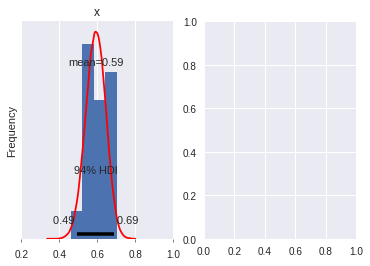

In [51]:
fig, ax = plt.subplots(1, 2)
ex3.query("`grpctr` == 1")["accur01"].plot(kind="hist", bins=4, xlim=(0.2, 1.0), ax=ax[0])
az.plot_posterior(np.random.beta(omega.mean(), tau.mean(), 100_000), ax=ax[0], c="r");

In [53]:
grpctr_mu_neg1 = jnp.concatenate(
    [
        jnp.ones((ex3.query("`grpctr` == -1").shape[0], 1)),
        ex3.query("`grpctr` == -1")[["grpctr", "ziq"]].values,
        (ex3.query("`grpctr` == -1")["grpctr"]*ex3.query("`grpctr` == -1")["ziq"]).values[:,None]
    ],
    axis=1,
)

grpctr_phi_neg1 = jnp.concatenate(
    [
        jnp.ones((ex3.query("`grpctr` == -1").shape[0], 1)),
        ex3.query("`grpctr` == -1")[["grpctr", "ziq"]].values,
    ],
    axis=1,
)

mu_neg1 = expit(jnp.sum(mcmc.get_samples()["betas"].mean(0) * grpctr_mu_neg1, axis=-1))
phi_neg1 = jnp.exp(-(jnp.sum(mcmc.get_samples()["deltas"].mean(0) * grpctr_phi_neg1, axis=-1)))

In [54]:
grpctr_mu_neg1

DeviceArray([[ 1.   , -1.   ,  0.827, -0.827],
             [ 1.   , -1.   ,  0.59 , -0.59 ],
             [ 1.   , -1.   ,  0.471, -0.471],
             [ 1.   , -1.   ,  1.144, -1.144],
             [ 1.   , -1.   , -0.676,  0.676],
             [ 1.   , -1.   , -0.795,  0.795],
             [ 1.   , -1.   , -0.281,  0.281],
             [ 1.   , -1.   , -0.914,  0.914],
             [ 1.   , -1.   , -0.043,  0.043],
             [ 1.   , -1.   ,  0.907, -0.907],
             [ 1.   , -1.   ,  0.511, -0.511],
             [ 1.   , -1.   ,  1.223, -1.223],
             [ 1.   , -1.   ,  0.59 , -0.59 ],
             [ 1.   , -1.   ,  1.856, -1.856],
             [ 1.   , -1.   , -0.399,  0.399],
             [ 1.   , -1.   ,  0.59 , -0.59 ],
             [ 1.   , -1.   , -0.043,  0.043],
             [ 1.   , -1.   ,  1.738, -1.738],
             [ 1.   , -1.   ,  0.471, -0.471],
             [ 1.   , -1.   ,  1.619, -1.619],
             [ 1.   , -1.   ,  1.144, -1.144],
             

In [55]:
mu_neg1.mean(), phi_neg1.mean()

(DeviceArray(0.8939219, dtype=float32), DeviceArray(10.85386, dtype=float32))

In [56]:
omega = mu_neg1 * phi_neg1
tau = phi_neg1 - mu_neg1 * phi_neg1
omega.mean(), tau.mean()

(DeviceArray(10.195054, dtype=float32), DeviceArray(0.6588058, dtype=float32))

In [57]:
np.random.beta(omega.mean(), tau.mean(), 10)

array([0.99894786, 0.95584599, 0.96057316, 0.9452623 , 0.9907822 ,
       0.97752126, 0.94005121, 0.99689875, 0.89258116, 0.95542954])

In [58]:
ex3.query("`grpctr` == -1")["accur01"].plot(kind="hist", bins=4, xlim=(0.2, 1.0), ax=ax[1])
az.plot_posterior(np.random.beta(omega.mean(), tau.mean(), 100_000), ax=ax[1], c="r")

<AxesSubplot:title={'center':'x'}, ylabel='Frequency'>

In [59]:
fig.tight_layout()

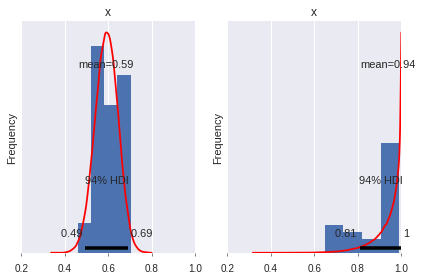

In [60]:
fig

In [61]:
def beta_regression_04(X, W, y=None):
    x_num_predictors = X.shape[1]
    w_num_predictors = W.shape[1]
    betas = numpyro.sample(
        "betas",
        dist.Normal(jnp.zeros(x_num_predictors), jnp.ones(x_num_predictors) * 10),
    )
    mu = expit(jnp.sum(betas * X, axis=-1))
    deltas = numpyro.sample(
        "deltas",
        dist.Normal(jnp.zeros(w_num_predictors), jnp.ones(w_num_predictors) * 10),
    )
    phi = jnp.exp(-(jnp.sum(deltas * W, axis=-1)))

    return numpyro.sample("y", dist.BetaProportion(mu, phi), obs=y)

In [62]:
nuts_kernel = NUTS(beta_regression_04)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=2000, num_chains=4)
mcmc.run(keys[5], X, W, y, extra_fields=("potential_energy",))
mcmc.print_summary()

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 2500/2500 [00:01<00:00, 2157.00it/s, 15 steps of size 1.75e-01. acc. prob=0.91]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  betas[0]      1.13      0.15      1.13      0.88      1.37   2456.39      1.00
  betas[1]     -0.75      0.15     -0.75     -1.01     -0.51   2445.63      1.00
  betas[2]      0.44      0.17      0.44      0.17      0.74   2213.55      1.00
  betas[3]     -0.53      0.18     -0.53     -0.83     -0.24   2117.82      1.00
 deltas[0]     -3.14      0.24     -3.15     -3.55     -2.75   2945.76      1.00
 deltas[1]     -1.61      0.31     -1.62     -2.10     -1.10   2334.82      1.00
 deltas[2]     -1.05      0.45     -1.06     -1.80     -0.32   2075.16      1.00

Number of divergences: 4
